In [2]:
import numpy as np
import cupy as cp
import numpy.fft as fft
from numpy.fft import fft2, ifft2
import sigpy
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/batman/Documents/ma221/gfloat/src')
import pywt
import gfloat
print(dir(gfloat))
from gfloat.formats import *
from gfloat import decode_float
from scipy.linalg import cholesky
from pgd import *

['BlockFormatInfo', 'FloatClass', 'FloatValue', 'FormatInfo', 'RoundMode', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'block', 'compute_scale_amax', 'decode', 'decode_block', 'decode_float', 'decode_ndarray', 'encode', 'encode_block', 'encode_float', 'encode_ndarray', 'float_pow2str', 'float_tilde_unless_roundtrip_str', 'formats', 'printing', 'quantize_block', 'round', 'round_float', 'round_ndarray', 'types']


#### Get kspace and sensitivity maps

kspace: (8, 230, 180) complex64


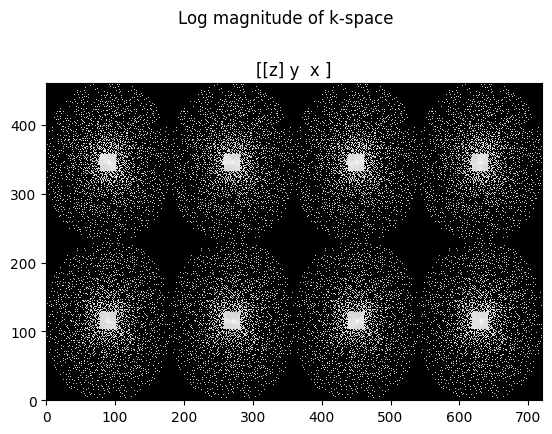

EspiritCalib: 100%|██████████| 100/100 [00:00<00:00, 154.96it/s]


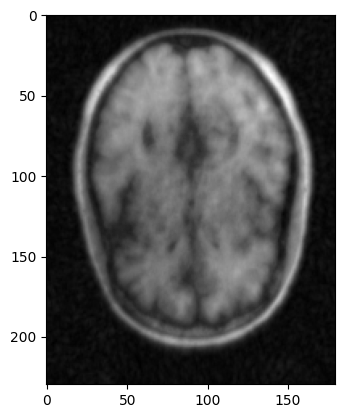

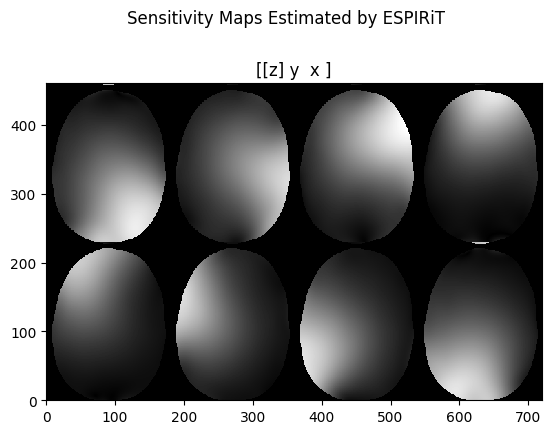

Sensitivity maps: (8, 230, 180) complex64


In [3]:
ksp_path = '/home/batman/Documents/sigpy_tutorial/sigpy-mri-tutorial/data/' # undersampled
#ksp_path = '/home/batman/Documents/ma221/proj_img/'
kspace = np.load(ksp_path + 'cartesian_ksp.npy')
print('kspace:', kspace.shape, kspace.dtype)
pl.ImagePlot(kspace, mode='l', z=0, title='Log magnitude of k-space')

# undersample
# mask = mr.poisson((ksp.shape[1], ksp.shape[2]), 4)
# uksp = ksp * mask

img_mc = np.abs(sigpy.ifft(kspace, axes=(-1, -2))) # image space multicoil
img_rss = np.sum(img_mc**2, axis=0)**0.5
plt.imshow(img_rss, cmap='gray')

# get smaps
mps = mr.app.EspiritCalib(kspace).run()
pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')
print('Sensitivity maps:', mps.shape, mps.dtype)

#### Pad k-space and smaps

(8, 256, 256)
(8, 256, 256)
[[[ 3.80216149e-17+4.99410626e-18j  1.15707559e-05-1.87306347e-04j
   -1.06721890e-05+2.23156522e-04j ... -9.25755451e-06+7.85620217e-05j
    2.31571201e-05-2.23156521e-04j -1.68092480e-05+1.87306347e-04j]
  [ 3.48036669e-18+1.33794381e-17j -2.13342904e-05-1.92137359e-04j
    2.92792645e-05+2.26291328e-04j ...  3.33831715e-06+8.32460844e-05j
   -1.35369864e-05-2.34935022e-04j  1.47242155e-05+1.95722834e-04j]
  [ 3.07822392e-18-7.97452111e-19j  1.52405432e-04-9.00623690e-05j
   -1.80843024e-04+1.12277331e-04j ... -6.47911191e-05+3.27276281e-05j
    1.83478665e-04-9.58624679e-05j -1.53500547e-04+8.32533483e-05j]
  ...
  [ 3.65032420e-17-1.69485604e-18j  9.76027968e-05+2.65445870e-05j
   -1.18347903e-04-2.47941506e-05j ... -3.77939459e-05-1.80609117e-05j
    1.09684129e-04+4.73232045e-05j -9.39604966e-05-3.58898245e-05j]
  [ 4.20152352e-19+7.40776984e-18j -7.42198694e-05-1.52243687e-04j
    9.19175075e-05+1.76405768e-04j ...  2.60165146e-05+6.89029574e-05j
   -

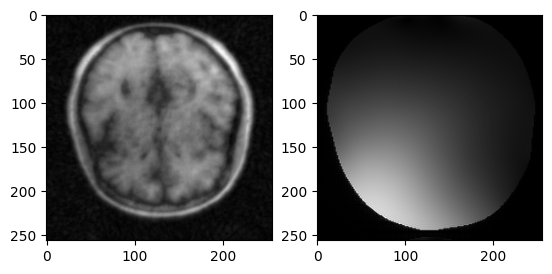

In [4]:
kspace_padded, sens_maps_padded = pad(kspace, mps)
img_mc_pad = np.abs(sigpy.ifft(kspace_padded, axes=(-1, -2))) # image space multicoil
img_rss_pad = np.sum(img_mc_pad**2, axis=0)**0.5
print(sens_maps_padded.shape)
plt.subplot(121)
plt.imshow(img_rss_pad, cmap='gray')
plt.subplot(122)
plt.imshow(np.abs(sens_maps_padded[0,:,:]), cmap='gray')
print(sens_maps_padded)

#### Make FP16 FFT Plan

(8, 256, 256, 2) float32
(8, 256, 512) float16
(8, 256, 256, 2) float32


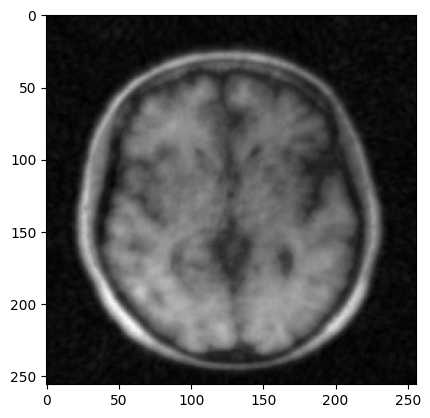

In [6]:
# define FP16 FFT helper function using tensor core
def fft_fp16(kspace):
    num_coils, h, w, _ = kspace.shape
    shape = (num_coils, h, w)

    # first move to GPU and convert to fp16
    kspace_gpu = cp.array(kspace).astype(cp.float16)

    # Apply ifftshift
    kspace_shifted = cp.fft.ifftshift(kspace_gpu)

    # data process input array for FFT plan
    # Reshape to have real/imag as last dimension doubled (real/imag separated into 2 channels)
    a = kspace_shifted.reshape(num_coils, h, 2*w)
    out = cp.empty_like(a)

    # create FFT plan
    plan = cp.cuda.cufft.XtPlanNd(shape[1:],          # input shape
                            shape[1:],           # output shape
                            1,                   # batch stride
                            h*w,                # element stride
                            'E',                # input type (complex32)
                            shape[1:],          # output shape
                            1,                   # batch stride
                            h*w,                # element stride
                            'E',                # output type (complex32)
                            num_coils,          # batch size
                            'E',                # execution type
                            order='C',
                            last_axis=-1,
                            last_size=None)

    # do FFT here; if h or w not pow2 it will error
    plan.fft(a, out, cp.cuda.cufft.CUFFT_FORWARD) # out here is fp16
    print(out.shape, out.dtype)

    out = out.astype(cp.float32)
    # reshape back to original format
    out = out.reshape(num_coils, h, w, 2)

    print(out.shape, out.dtype)

    # convert to complex-valued array
    out_complex = out.view(cp.complex64)

    # shift in img space
    img = cp.fft.fftshift(out_complex)

    img_fp16 = cp.asnumpy(img) # detatch from gpu
    img_fp16 = np.sqrt(np.sum(np.abs(img_fp16)**2, axis=0)) #rss
    return img_fp16

def view_as_real(x):
    out_shape = x.shape + (2,)
    result = np.empty(out_shape, dtype=x.real.dtype)
    result[..., 0] = x.real
    result[..., 1] = x.imag
    return result

padded_kspace = view_as_real(kspace_padded)
print(padded_kspace.shape, padded_kspace.dtype)
img_16 = fft_fp16(padded_kspace)
plt.imshow(np.flip(np.abs(img_16)), cmap='gray')

#### Vanilla L1-wavelet recon FP32

/home/batman/Documents/ma221/pgd.py:141: RuntimeWarning: invalid value encountered in divide
  sign = np.where(np.abs(x) == 0, 0, x/np.abs(x))


Text(0.5, 1.0, 'FP32')

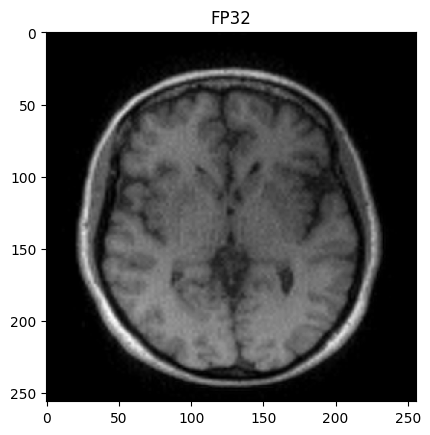

In [5]:
recon_img = l1_wavelet_recon(kspace_padded, sens_maps_padded, num_iters=50, lamda=1e-2)
plt.imshow(np.abs(np.flip(recon_img)), cmap='gray')

#### CG with FP16 FFT on Tensor core

/home/batman/Documents/ma221/pgd.py:327: RuntimeWarning: invalid value encountered in divide
  sign = np.where(np.abs(x) == 0, 0, x/np.abs(x))


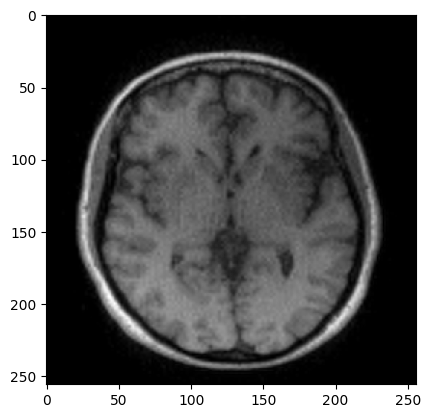

In [7]:
img_16 = l1_wavelet_recon_fp16(kspace_padded, sens_maps_padded, num_iters=50, lamda=1e-2)
plt.imshow(np.abs(np.flip(img_16)), cmap='gray')
